In [1]:
#author: Aravinda Raman J (aravindaraman04@gmail.com)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys
import time
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import tensorflow as tf
import keras
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv('grenoble.csv',
                 parse_dates=['datetime'],
                 infer_datetime_format=True,
                 index_col='datetime')              

In [3]:
df.shape

(108659, 7)

In [4]:
target_names = np.array('target_names')

In [5]:
count_bad=(df['target_names']=='Bad').sum()
print(count_bad)

10220


In [6]:
count_interm=(df['target_names']=='Interm.').sum()
print(count_interm)

13017


In [7]:
count_good=(df['target_names']=='Good').sum()
print(count_good)

85422


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108659 entries, 2018-01-11 16:32:22 to 2018-01-13 16:21:20
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   src           108659 non-null  int64  
 1   dst           108659 non-null  int64  
 2   channel       108659 non-null  int64  
 3   mean_rssi     108659 non-null  float64
 4   pdr           108659 non-null  float64
 5   tx_count      108659 non-null  int64  
 6   target_names  108659 non-null  object 
dtypes: float64(2), int64(4), object(1)
memory usage: 6.6+ MB


In [9]:
df

,src,dst,channel,mean_rssi,pdr,tx_count,target_names
datetime,,,,,,,
2018-01-11 16:32:22,0,18,11,-5.90,1.0,100,Good
2018-01-11 16:32:22,0,7,11,-70.74,1.0,100,Good
2018-01-11 16:32:22,0,42,11,-80.06,0.6,100,Interm.
2018-01-11 16:32:22,0,28,11,-68.46,1.0,100,Good
2018-01-11 16:32:22,0,12,11,-71.84,0.6,100,Interm.
...,...,...,...,...,...,...,...
2018-01-13 16:21:20,49,28,26,-75.13,1.0,100,Good
2018-01-13 16:21:20,49,37,26,-68.39,1.0,100,Good
2018-01-13 16:21:20,49,13,26,-74.39,1.0,100,Good


In [10]:
df.describe()

,src,dst,channel,mean_rssi,pdr,tx_count
count,108659.000000,108659.000000,108659.000000,108659.000000,108659.000000,108659.0
mean,24.923485,25.047387,18.376895,-74.550728,0.874964,100.0
std,14.831090,14.836094,4.579974,11.870855,0.248361,0.0
min,0.000000,0.000000,11.000000,-91.000000,0.010000,100.0
25%,12.000000,13.000000,14.000000,-85.770000,0.910000,100.0
50%,25.000000,25.000000,18.000000,-76.570000,1.000000,100.0
75%,39.000000,40.000000,22.000000,-66.970000,1.000000,100.0
max,49.000000,49.000000,26.000000,-5.900000,1.000000,100.0


In [11]:
features = df[['mean_rssi','pdr']]
target_names = df[['target_names']]              

In [12]:
features

,mean_rssi,pdr
datetime,,
2018-01-11 16:32:22,-5.90,1.0
2018-01-11 16:32:22,-70.74,1.0
2018-01-11 16:32:22,-80.06,0.6
2018-01-11 16:32:22,-68.46,1.0
2018-01-11 16:32:22,-71.84,0.6
...,...,...
2018-01-13 16:21:20,-75.13,1.0
2018-01-13 16:21:20,-68.39,1.0
2018-01-13 16:21:20,-74.39,1.0


In [13]:
# Split train and test data
train_features = features.loc['2018-01-11 16:32:22':'2018-01-13 06:43:02']
train_labels = target_names.loc['2018-01-11 16:32:22':'2018-01-13 06:43:02','target_names']

test_features = features.loc['2018-01-13 06:43:02':'2018-01-13 16:21:20']
test_labels = target_names.loc['2018-01-13 06:43:02':'2018-01-13 16:21:20','target_names']

# I want to use a T-days window of input data for predicting target_class
# It means I need to prepend (T-1) last train records to the 1st test window

T = 30  # my choice of the timesteps window

prepend_features = train_features.iloc[-(T-1):]
test_features = pd.concat([prepend_features, test_features], axis=0)

train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((86928, 2), (86928,), (21763, 2), (21734,))

In [57]:
# Rescale the features
from sklearn.preprocessing import StandardScaler  # MinMaxScaler

scaler = StandardScaler()  # MinMaxScaler(feature_range=(-1,1))
scaled_train_features = pd.DataFrame(scaler.fit_transform(train_features.values),
                                     index=train_features.index,
                                     columns=train_features.columns)
# The Scaler is fit on the training set and then applied to the test set
scaled_test_features = pd.DataFrame(scaler.transform(test_features.values),
                                    index=test_features.index,
                                    columns=test_features.columns)

scaled_train_features.shape, scaled_test_features.shape

((86928, 2), (21763, 2))

In [15]:
scaled_train_features

,mean_rssi,pdr
datetime,,
2018-01-11 16:32:22,5.784865,0.506994
2018-01-11 16:32:22,0.321264,0.506994
2018-01-11 16:32:22,-0.464066,-1.095007
2018-01-11 16:32:22,0.513383,0.506994
2018-01-11 16:32:22,0.228575,-1.095007
...,...,...
2018-01-13 06:42:51,0.975143,0.506994
2018-01-13 06:42:51,-0.857573,0.506994
2018-01-13 06:43:02,0.939753,0.506994


In [16]:
scaled_test_features

,mean_rssi,pdr
datetime,,
2018-01-13 06:42:29,0.519281,0.506994
2018-01-13 06:42:29,-1.129742,-2.656958
2018-01-13 06:42:29,0.387831,0.506994
2018-01-13 06:42:29,-1.070758,-1.815908
2018-01-13 06:42:30,-1.235070,-3.257709
...,...,...
2018-01-13 16:21:20,-0.048650,0.506994
2018-01-13 16:21:20,0.519281,0.506994
2018-01-13 16:21:20,0.013705,0.506994


In [58]:
# Create sequences of T timesteps
X_train, y_train = [], []
for i in range(train_labels.shape[0] - (T-1)):
    X_train.append(scaled_train_features.iloc[i:i+T].values)
    y_train.append(train_labels.iloc[i + (T-1)])
X_train, y_train = np.array(X_train), np.array(y_train).reshape(-1,1)
print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')

X_test, y_test = [], []
for i in range(test_labels.shape[0]):
    X_test.append(scaled_test_features.iloc[i:i+T].values)
    y_test.append(test_labels.iloc[i])
X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1,1)  

print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')

Train data dimensions: (86899, 30, 2), (86899, 1)
Test data dimensions: (21734, 30, 2), (21734, 1)


In [59]:
y_train = pd.DataFrame(y_train)
y_train.head(102)

,0
0,Good
1,Good
2,Good
3,Good
4,Good
...,...
97,Good
98,Interm.
99,Good
100,Good


In [60]:
y_train = pd.DataFrame(y_train)
y_train = pd.get_dummies(y_train)

In [61]:
y_train

,0_Bad,0_Good,0_Interm.
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
86894,0,1,0
86895,0,1,0
86896,0,1,0
86897,0,1,0


In [62]:
y_train = np.array(y_train)
print(y_train.shape)
y_train

(86899, 3)


array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=uint8)

In [63]:
y_test = pd.DataFrame(y_test)
y_test = pd.get_dummies(y_test)
y_test 

,0_Bad,0_Good,0_Interm.
0,0,1,0
1,0,1,0
2,0,1,0
3,0,0,1
4,1,0,0
...,...,...,...
21729,0,1,0
21730,0,1,0
21731,0,1,0
21732,0,1,0


In [64]:
y_test = np.array(y_test)
print(y_test.shape)
y_test

(21734, 3)


array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=uint8)

In [65]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(86899, 30, 2)
(21734, 30, 2)
(86899, 3)
(21734, 3)


In [25]:
T

30

In [29]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from time import time

In [30]:
tf.random.set_seed(0)

In [32]:
# Let's make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 3]                # number of units in hidden and output layers
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH =  13                         # number of epochs
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'dropout = {DP}, recurr_dropout = {RDP}')

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='sigmoid',
               kernel_regularizer=None, recurrent_regularizer=None,
               return_sequences=True, recurrent_dropout=RDP, dropout=DP
               ))

model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='sigmoid',
               kernel_regularizer=None, recurrent_regularizer=None,
               return_sequences=True, recurrent_dropout=RDP, dropout=DP
               ))

model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='sigmoid',
               kernel_regularizer=None, recurrent_regularizer=None,
               return_sequences=False, recurrent_dropout=RDP, dropout=DP
               ))

model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='softmax'))

print(model.summary())

layers=[8, 8, 8, 3], train_examples=86899, test_examples=21734
batch = 86899, timesteps = 30, features = 2, epochs = 13
dropout = 0.0, recurr_dropout = 0.0
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 8)             352       
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 8)             32        
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 8)             544       
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 8)             32        
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 544       
_________________________________________________________________
batch_normalization_5 (Batch (

In [33]:
# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

In [34]:
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()
History = model.fit(X_train, y_train,
                    epochs=EPOCH,
                    validation_split=0.0,
                    validation_data=(X_test[:M_TEST], y_test[:M_TEST]),
                    verbose=2)

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train, y_train,
                                       batch_size=M_TRAIN, verbose=1)
test_loss, test_acc = model.evaluate(X_test[:M_TEST], y_test[:M_TEST],
                                     batch_size=M_TEST, verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')


Epoch 1/13
2716/2716 - 101s - loss: 0.1483 - accuracy: 0.9474 - val_loss: 0.0252 - val_accuracy: 0.9905
Epoch 2/13
2716/2716 - 96s - loss: 0.0388 - accuracy: 0.9850 - val_loss: 0.0218 - val_accuracy: 0.9908
Epoch 3/13
2716/2716 - 95s - loss: 0.0334 - accuracy: 0.9874 - val_loss: 0.0235 - val_accuracy: 0.9916
Epoch 4/13
2716/2716 - 94s - loss: 0.0297 - accuracy: 0.9887 - val_loss: 0.0213 - val_accuracy: 0.9905
Epoch 5/13
2716/2716 - 97s - loss: 0.0280 - accuracy: 0.9891 - val_loss: 0.0174 - val_accuracy: 0.9923
Epoch 6/13
2716/2716 - 95s - loss: 0.0252 - accuracy: 0.9902 - val_loss: 0.0146 - val_accuracy: 0.9944
Epoch 7/13
2716/2716 - 95s - loss: 0.0243 - accuracy: 0.9906 - val_loss: 0.0172 - val_accuracy: 0.9927
Epoch 8/13
2716/2716 - 95s - loss: 0.0222 - accuracy: 0.9913 - val_loss: 0.0158 - val_accuracy: 0.9931
Epoch 9/13
2716/2716 - 94s - loss: 0.0198 - accuracy: 0.9919 - val_loss: 0.0136 - val_accuracy: 0.9942
Epoch 10/13
2716/2716 - 94s - loss: 0.0187 - accuracy: 0.9930 - val_loss

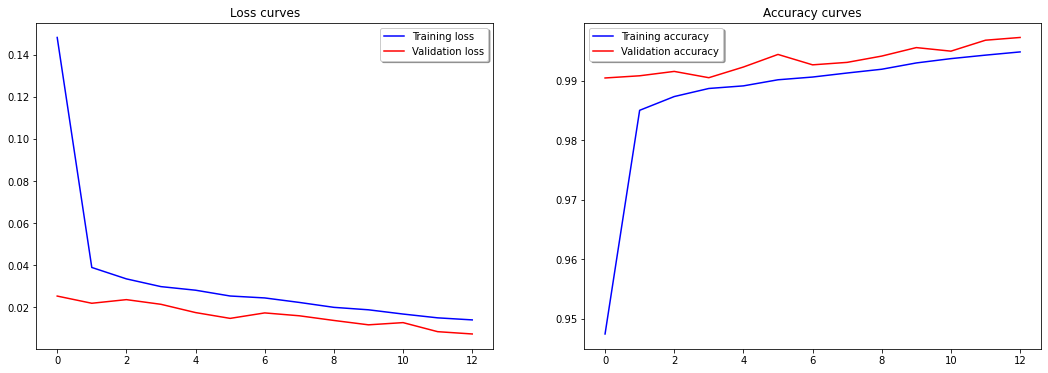

In [35]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
#model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#history  = model.fit(X_train,y_train,epochs=2,batch_size=32,validation_data=(X_test,y_test))

In [ ]:
#model.evaluate(X_test,y_test)

In [ ]:
#y_pred = model.predict(X_test)

In [ ]:
#y_pred

In [ ]:
#predict_class = np.argmax(y_pred, axis=1)
#predict_class = predict_class

In [ ]:
#predict_class

In [ ]:
#from sklearn.neighbors import KNeighborsClassifier
#classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
#classifier.fit(X_train, y_train)

In [ ]:
#y_pred = np.array(y_train)
#y_test = np.array(y_test)

In [ ]:
#y_pred = classifier.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

In [ ]:
#from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
#conf = confusion_matrix(y_pred,y_test)
#acc = accuracy_score(y_pred,y_test)
#report = classification_report(y_pred,y_test)

In [ ]:
#print(report)

In [66]:
y_test

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=uint8)

In [67]:
y_test = pd.DataFrame(y_test)
y_test=np.argmax(y_test.iloc[:,:].values, axis=1)
y_test

array([1, 1, 1, ..., 1, 1, 1])

In [68]:
y_pred = np.argmax(model.predict(X_test, batch_size=M_TEST, verbose=1),axis=-1)
score = sum(y_pred == y_test) / len(y_test)
print(f'Prediction accuracy = {score*100}%')
index = pd.date_range(start='2018-01-13 06:43:02', end='2018-01-13 16:21:20', freq='H')
for i in range(y_pred.shape[0]):
    print(index[i], y_pred[i], y_test[i])

1/1 [==============================] - 1s 567ms/step
Prediction accuracy = 99.72853593448053%
2018-01-13 06:43:02 1 1
2018-01-13 07:43:02 1 1
2018-01-13 08:43:02 1 1
2018-01-13 09:43:02 2 2
2018-01-13 10:43:02 0 0
2018-01-13 11:43:02 2 2
2018-01-13 12:43:02 2 2
2018-01-13 13:43:02 2 2
2018-01-13 14:43:02 1 1
2018-01-13 15:43:02 1 1


IndexError: ignored

In [69]:
y_test

array([1, 1, 1, ..., 1, 1, 1])

In [70]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [71]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
conf = confusion_matrix(y_pred,y_test)
acc = accuracy_score(y_pred,y_test)*100
report = classification_report(y_pred,y_test)

In [72]:
print(conf)

[[ 1928     0    26]
 [    0 17271     6]
 [   23     4  2476]]


In [73]:
print(f'{acc:.2f} %')

99.73 %


In [74]:
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1954
           1       1.00      1.00      1.00     17277
           2       0.99      0.99      0.99      2503

    accuracy                           1.00     21734
   macro avg       0.99      0.99      0.99     21734
weighted avg       1.00      1.00      1.00     21734



In [75]:
y_pred = y_pred.astype(object)
y_pred[y_pred==0] = 'Bad'
y_pred[y_pred==1] = 'Good'
y_pred[y_pred==2] = 'Interm'

In [76]:
y_pred

array(['Good', 'Good', 'Good', ..., 'Good', 'Good', 'Good'], dtype=object)

In [77]:
y_test= y_test.astype(object)
y_test[y_test==0] = 'Bad'
y_test[y_test==1] = 'Good'
y_test[y_test==2] = 'Interm'

In [78]:
y_test

array(['Good', 'Good', 'Good', ..., 'Good', 'Good', 'Good'], dtype=object)

In [79]:
comparision=np.concatenate((y_test.reshape(len(y_test),1), y_pred.reshape(len(y_pred),1)),1)
print(comparision)

[['Good' 'Good']
 ['Good' 'Good']
 ['Good' 'Good']
 ...
 ['Good' 'Good']
 ['Good' 'Good']
 ['Good' 'Good']]


In [80]:
score = sum(y_pred == y_test) / len(y_test)
print(f'Prediction accuracy = {score*100}%')
index = pd.date_range(start='2018-01-13 06:43:02', end='2018-01-13 16:21:20', freq='H')
for i in range(y_pred.shape[0]):
   print(index[i], y_pred[i], y_test[i])

Prediction accuracy = 99.72853593448053%
2018-01-13 06:43:02 Good Good
2018-01-13 07:43:02 Good Good
2018-01-13 08:43:02 Good Good
2018-01-13 09:43:02 Interm Interm
2018-01-13 10:43:02 Bad Bad
2018-01-13 11:43:02 Interm Interm
2018-01-13 12:43:02 Interm Interm
2018-01-13 13:43:02 Interm Interm
2018-01-13 14:43:02 Good Good
2018-01-13 15:43:02 Good Good


IndexError: ignored

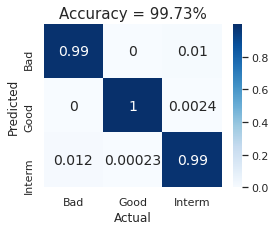

In [81]:
data = confusion_matrix(y_pred, y_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Predicted'
df_cm.columns.name = 'Actual'

plt.figure(figsize = (4,3))

sns.set(font_scale=1)#for label size
sns.heatmap(df_cm/np.sum(df_cm), cmap="Blues",annot=True,annot_kws={"size": 14})# font size
plt.title(f'Accuracy = {round(acc, 2)}%', fontsize = 15)
plt.show()

In [83]:
y_pred = np.array(y_pred)
y_pred = pd.DataFrame(y_pred)
y_pred

,0
0,Good
1,Good
2,Good
3,Interm
4,Bad
...,...
21729,Good
21730,Good
21731,Good
21732,Good


In [84]:
y_test = pd.DataFrame(y_test)
y_test

,0
0,Good
1,Good
2,Good
3,Interm
4,Bad
...,...
21729,Good
21730,Good
21731,Good
21732,Good


In [85]:
y_test = np.array(y_test)
y_pred = np.array(y_pred)

In [86]:
# with the following sentence you can get a mask of the items bad classified
mask = np.logical_not(np.equal(y_test, y_pred))
# Now you can use the mask to see the elements bad classified:
print(f"Elements wrong classified: {y_test[mask]}")
print(f"Prediction by the model for each of those elements: {y_pred[mask]}")
print(f"Actual value for each of those elements: {np.asarray(y_test)[mask]}")

Elements wrong classified: ['Interm' 'Bad' 'Good' 'Interm' 'Interm' 'Interm' 'Interm' 'Bad' 'Good'
 'Interm' 'Bad' 'Bad' 'Interm' 'Interm' 'Interm' 'Interm' 'Bad' 'Good'
 'Bad' 'Bad' 'Interm' 'Interm' 'Interm' 'Bad' 'Interm' 'Interm' 'Bad'
 'Bad' 'Bad' 'Bad' 'Interm' 'Good' 'Interm' 'Bad' 'Interm' 'Interm' 'Bad'
 'Bad' 'Bad' 'Interm' 'Interm' 'Interm' 'Interm' 'Interm' 'Bad' 'Bad'
 'Bad' 'Interm' 'Bad' 'Interm' 'Interm' 'Interm' 'Bad' 'Interm' 'Interm'
 'Interm' 'Interm' 'Bad' 'Bad']
Prediction by the model for each of those elements: ['Bad' 'Interm' 'Interm' 'Good' 'Bad' 'Bad' 'Bad' 'Interm' 'Interm' 'Good'
 'Interm' 'Interm' 'Good' 'Bad' 'Bad' 'Good' 'Interm' 'Interm' 'Interm'
 'Interm' 'Bad' 'Bad' 'Bad' 'Interm' 'Bad' 'Bad' 'Interm' 'Interm'
 'Interm' 'Interm' 'Bad' 'Interm' 'Good' 'Interm' 'Bad' 'Bad' 'Interm'
 'Interm' 'Interm' 'Bad' 'Bad' 'Bad' 'Bad' 'Bad' 'Interm' 'Interm'
 'Interm' 'Bad' 'Interm' 'Bad' 'Bad' 'Bad' 'Interm' 'Good' 'Bad' 'Bad'
 'Bad' 'Interm' 'Interm']
Actual val

In [87]:
Prediction=y_pred[mask]
Prediction


array(['Bad', 'Interm', 'Interm', 'Good', 'Bad', 'Bad', 'Bad', 'Interm',
       'Interm', 'Good', 'Interm', 'Interm', 'Good', 'Bad', 'Bad', 'Good',
       'Interm', 'Interm', 'Interm', 'Interm', 'Bad', 'Bad', 'Bad',
       'Interm', 'Bad', 'Bad', 'Interm', 'Interm', 'Interm', 'Interm',
       'Bad', 'Interm', 'Good', 'Interm', 'Bad', 'Bad', 'Interm',
       'Interm', 'Interm', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Interm',
       'Interm', 'Interm', 'Bad', 'Interm', 'Bad', 'Bad', 'Bad', 'Interm',
       'Good', 'Bad', 'Bad', 'Bad', 'Interm', 'Interm'], dtype=object)

In [88]:
Actual=y_test[mask]
Actual

array(['Interm', 'Bad', 'Good', 'Interm', 'Interm', 'Interm', 'Interm',
       'Bad', 'Good', 'Interm', 'Bad', 'Bad', 'Interm', 'Interm',
       'Interm', 'Interm', 'Bad', 'Good', 'Bad', 'Bad', 'Interm',
       'Interm', 'Interm', 'Bad', 'Interm', 'Interm', 'Bad', 'Bad', 'Bad',
       'Bad', 'Interm', 'Good', 'Interm', 'Bad', 'Interm', 'Interm',
       'Bad', 'Bad', 'Bad', 'Interm', 'Interm', 'Interm', 'Interm',
       'Interm', 'Bad', 'Bad', 'Bad', 'Interm', 'Bad', 'Interm', 'Interm',
       'Interm', 'Bad', 'Interm', 'Interm', 'Interm', 'Interm', 'Bad',
       'Bad'], dtype=object)

In [89]:
comp=np.concatenate((Actual.reshape(len(Actual),1), Prediction.reshape(len(Prediction),1)),1)
comp = pd.DataFrame(comp)
comp.columns=['Actual','Predicted']
comp

,Actual,Predicted
0,Interm,Bad
1,Bad,Interm
2,Good,Interm
3,Interm,Good
4,Interm,Bad
5,Interm,Bad
6,Interm,Bad
7,Bad,Interm
8,Good,Interm
9,Interm,Good


In [100]:
comp1=np.array(comp['Predicted'])

In [101]:
comp1

array(['Bad', 'Interm', 'Interm', 'Good', 'Bad', 'Bad', 'Bad', 'Interm',
       'Interm', 'Good', 'Interm', 'Interm', 'Good', 'Bad', 'Bad', 'Good',
       'Interm', 'Interm', 'Interm', 'Interm', 'Bad', 'Bad', 'Bad',
       'Interm', 'Bad', 'Bad', 'Interm', 'Interm', 'Interm', 'Interm',
       'Bad', 'Interm', 'Good', 'Interm', 'Bad', 'Bad', 'Interm',
       'Interm', 'Interm', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Interm',
       'Interm', 'Interm', 'Bad', 'Interm', 'Bad', 'Bad', 'Bad', 'Interm',
       'Good', 'Bad', 'Bad', 'Bad', 'Interm', 'Interm'], dtype=object)

In [118]:
comp1=pd.DataFrame(comp1)
comp1

,0
0,Bad
1,Interm
2,Interm
3,Good
4,Bad
5,Bad
6,Bad
7,Interm
8,Interm
9,Good


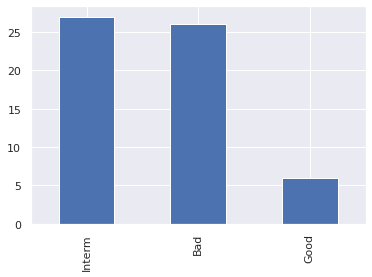

In [121]:
comp1[0].value_counts().plot(kind='bar')

In [129]:
sum1=comp1[comp1[0]=='Interm'].value_counts()
print(sum1)

Interm    27
dtype: int64


In [130]:
sum1=comp1[comp1[0]=='Bad'].value_counts()
print(sum1)

Bad    26
dtype: int64


In [131]:
sum1=comp1[comp1[0]=='Good'].value_counts()
print(sum1)

Good    6
dtype: int64
